In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#22% 13:00
#48% 13:30
#66% 14:00
#79% 14:30
#93% 15:00

### Homework part I: Prohibited Comment Classification (3 points)

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this notebook__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [67]:
!wget https://raw.githubusercontent.com/Dimfeel/nlp_course/2020/week02_classification/comments.tsv -O comments.tsv

--2021-07-18 11:16:13--  https://raw.githubusercontent.com/Dimfeel/nlp_course/2020/week02_classification/comments.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353358 (345K) [text/plain]
Saving to: ‘comments.tsv’

comments.tsv        100%[===================>] 345.08K  --.-KB/s    in 0.008s  

2021-07-18 11:16:13 (44.3 MB/s) - ‘comments.tsv’ saved [353358/353358]



In [68]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [69]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

In [70]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))


text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [71]:
# task: preprocess each comment in train and test

texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

In [72]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. Please don't do that in the current assignment, though.
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [108]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
from collections import OrderedDict

k = 10000

words_frequency = {}

for text in texts_train:
  for word in text.split(" "):
    if word not in words_frequency:
      words_frequency[word] = 1
    else:
      words_frequency[word] += 1


words = sorted(words_frequency.items(), key=lambda item: item[1], reverse=True)
bow_vocabulary = [k for (k, v) in words]
bow_vocabulary = bow_vocabulary[:k]

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12/13', '3', ']', 'adolf', 'altered', 'arcane', 'automatically', 'benefit', 'bottom', 'cambefort', 'chemistry', 'comb-like', 'consume', 'credited', 'decided', 'diatribe', 'doing', 'education', 'essay', 'factual', 'fire', 'from', 'go', 'handle', 'himself', 'ideas', 'info', "israel's", 'killings', 'let', 'losers', 'mckay', 'moderately', 'national', 'nothing', 'oppose', 'paying', 'plan', 'pressure', 'pump', 'reasoning', 'repeatedly', 'rfd', 'school', 'sheep', 'slight', 'spin', 'stuffed', 'systemic', 'themselves', 'toot', 'uer', 'userpage', 'wannabe', 'wiki', 'yank', 'ா']


In [109]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    bow = [0]*len(bow_vocabulary)
    for word in text.split(" "):
      if word in bow_vocabulary:
        bow[bow_vocabulary.index(word)] += 1
    
    return np.array(bow, 'float32')

In [110]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [112]:
k_max = len(bow_vocabulary)
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

__Naive bayes:__ perhaps the simplest model that can solve your problem is the so called Naive Bayes Classifier. 
Its a trivial linear model that assumes the independence of input features and computes the coefficients by, well, counting probabilities.

If you don't remember the math behind Naive Bayes, read [this chunk](https://lena-voita.github.io/nlp_course/text_classification.html#naive_bayes) to help refresh your memory. Done? Good! Now let's implement that :)

In [158]:
class BinaryNaiveBayes:
    delta = 1.0  # add this to all word counts to smoothe probabilities
    
    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        # first, compute marginal probabilities of every class, p(y=k) for k = 0,1
        self.p_y = np.array( [(y==k).sum()/len(y) for k in [0, 1]])
        
        # count occurences of each word in texts with label 1 and label 0 separately
        word_counts_positive = np.sum(X[y==1], axis=0)
        word_counts_negative = np.sum(X[y==0], axis=0)
        # ^-- both must be vectors of shape [vocab_size].
        
        # finally, lets use those counts to estimate p(x | y = k) for k = 0, 1

        self.p_x_given_positive = (self.delta + word_counts_positive) / (self.delta*len(word_counts_positive) + np.sum(word_counts_positive))
        self.p_x_given_negative = (self.delta + word_counts_negative) / (self.delta*len(word_counts_negative) + np.sum(word_counts_negative))
        # both must be of shape [vocab_size]; and don't forget to add self.delta!
        
        return self
    
    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
        # compute scores for positive and negative classes separately.
        # these scores should be proportional to log-probabilities of the respective target {0, 1}
        # note: if you apply logarithm to p_x_given_*, the total log-probability can be written
        # as a dot-product with X

        score_negative = np.array( [ np.log(self.p_y[0]) + np.sum(np.log(x[x!=0]*self.p_x_given_negative[x!=0])) for x in X] )
        score_positive = np.array( [ np.log(self.p_y[1]) + np.sum(np.log(x[x!=0]*self.p_x_given_positive[x!=0])) for x in X] )
        
        # you can compute total p(x | y=k) with a dot product
        return np.stack([score_negative, score_positive], axis=-1)
    
    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)

In [159]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [160]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

f_index = bow_vocabulary.index('fuck')  # offensive tweets should contain more of this
assert naive_model.p_x_given_positive[f_index] > naive_model.p_x_given_negative[f_index]

g_index = bow_vocabulary.index('good')  # offensive tweets should contain less of this
assert naive_model.p_x_given_positive[g_index] < naive_model.p_x_given_negative[g_index]

Model accuracy: 0.770
Well done!


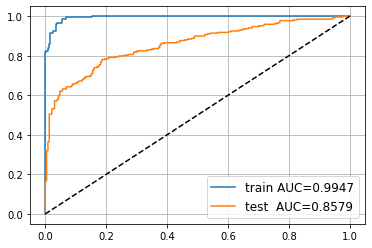

In [161]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

Okay, it definitely learned *something*. Now let's figure out what exactly it learned. The simplest way to do that is by highlighting which words have a greatest ratio of positive to negative probability or vice versa. We'll go with the negative one [because reasons](https://www.urbandictionary.com/define.php?term=because%20reasons).

__Your task__ is to compute top-25 words that have the __highest__ ratio of ${p(x_i | y=0)} \over {p(x_i | y=1)}$. Enjoy!

In [170]:
# hint: use naive_model.p_*
probability_ratio = (naive_model.p_x_given_negative * naive_model.p_y[0])/(naive_model.p_x_given_positive * naive_model.p_y[1])
top_negative_words = [bow_vocabulary[i] for i in np.argsort(probability_ratio)[:25]]

assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]
assert 'j.delanoy' in top_negative_words and 'college' in top_negative_words

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[bow_vocabulary.index(word)]})")

#0	    hitler	(ratio=0.002280500018969178)
#1	      heil	(ratio=0.0022982240188866854)
#2	   offfuck	(ratio=0.002457380760461092)
#3	      suck	(ratio=0.0034451044630259275)
#4	    nigger	(ratio=0.004847620148211718)
#5	 j.delanoy	(ratio=0.004928413312882185)
#6	      dick	(ratio=0.005798133555799723)
#7	      fggt	(ratio=0.011088930070400238)
#8	     bitch	(ratio=0.018104376271367073)
#9	      fuck	(ratio=0.020161692053079605)
#10	      slap	(ratio=0.02464206889271736)
#11	      shit	(ratio=0.02464206889271736)
#12	   fucking	(ratio=0.03411978483200073)
#13	       ass	(ratio=0.04032338410615921)
#14	    stupid	(ratio=0.05914096534252167)
#15	         =	(ratio=0.06181982159614563)
#16	   college	(ratio=0.06336531788110733)
#17	         *	(ratio=0.06336531788110733)
#18	   asshole	(ratio=0.06823956966400146)
#19	         u	(ratio=0.07096915692090988)
#20	       hit	(ratio=0.07392620295286179)
#21	   bastard	(ratio=0.07392620295286179)
#22	         @	(ratio=0.08064676821231842)
#23	     

Now lets try something less prehistoric: __Logistic Regression__. Turns out, if you're using silicon instead of an abacus, you can find model weights by optimizing the log-probability of the answer. Though, of course, you don't even need to write it by hand anymore. Let's sklearn it!

In [203]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression(C=1e-1, max_iter=1e4).fit(X_train_bow, y_train)

Model accuracy: 0.776
Well done!


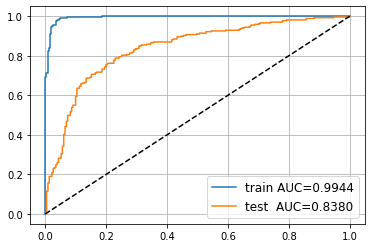

In [204]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }} $$


, where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :) You can still use 'em for debugging though.

In [211]:
class TFIDF:
  #delta = 1.0  # add this to all word counts to smoothe probabilities

  def tf(X, vocabulary):
    """
    Compute term frequency (TF) for words in document 
    :param X: [batch_size] of documents, where each document is the sentence
    of fitures separated by spaces
    :vocabulary: [vocab_size] of words, present in document in X
    """
    self.tf = np.zeros( (len(X), len(vocabulary)) )

    for i, sentence in enumerate(X):
      for sent_word in sentence.split(" "):
        if sent_word in vocabulary:
          self.tf[i,vocabulary.index(sent_word)] += 1
      self.tf[i] /= len(sentence.split(" "))

    return self

  def idf(X, vocabulary):
    """
    Compute inverse document frequency (IDF) for words 
    :param X: [batch_size] of documents, where each document is the sentence
    of fitures separated by spaces
    :vocabulary: [vocab_size] of words, present in document in X
    """
    self.idf = np.zeros(len(vocabulary))

    for i, voc_word in enumerate(vocabulary):
      for sentence in X:
        if word in sentence.split():
          self.idf[i] += 1
      self.idf[i] = log(len(X)/len(self.idf[i]))

    return self


...
"
henry
"
"
who
"
"
{
don't
warning
"
fine
a
ya'll
"
"
"
benidorm
effigy
12th
worm
"
"
dude
are
now
does
when
i
free
excuse
redirect
o
i'm
so
"
butts
brandon
not
so
ignorant
see
hanibal
people
"
"
bye
sarekofvulcan
your
"
i'm
a
land
go
"
furthermore
any
suxk
"
,
so
"
]
you
oh
"
"
unblock
heil
sorry
.
"
"
to
"
i'm
file
why
i
my
i
hey
based
"
bring
adolf
asshat
twit
"
my
"
thanks
hi
you
"
sidenote
"
=
that
hey
not
go
"
"
dahn
headline
your
"
ecw
way
attention
articles
usbecause
"
,
"
blind
"
|
"
article
busking
dont
if
and
but
seriously
fuck
block
did
lol
take
hey
teadrinker
"
"
yep
i
"
burn
you
fucking
its
sexuality
don't
hey
citing
fuck
get
it
information
lowlife
nigger
new
05:35
the
}
"
unacceptable
"
fuck
i
"
croke
i
you
kids
"
formal
please
fuck
i
"
please
also
"
ok
my
based
materials
what
"
"
"
nah
goal
hey
thank
and
go
fuck
i
"
i've
i
edit
timeslot
u
i
dcandeto
"
good
are
33
guess
"
run
let
conclusion
if
i
"
regarding
although
fight
hey
message
"
"
stay
i
hey
"
last
redirect
"

array([None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, No

### Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings
    * call `gensim.downloader.info()['models'].keys()` to get a list of available models
* clusterizing words by their word-vectors and try bag of cluster_ids

__Note:__ loading pre-trained model may take a while. It's a perfect opportunity to refill your cup of tea/coffee and grab some extra cookies. Or binge-watch some tv series if you're slow on internet connection

In [ ]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

# If you're low on RAM or download speed, use "glove-wiki-gigaword-100" instead. Ignore all further asserts.

In [ ]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.wv.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    
    <YOUR CODE>
    
    return features

assert np.allclose(
    vectorize_sum("who cares anymore . they attack with impunity .")[::70],
    np.array([ 0.0108616 ,  0.0261663 ,  0.13855131, -0.18510573, -0.46380025])
)

In [ ]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

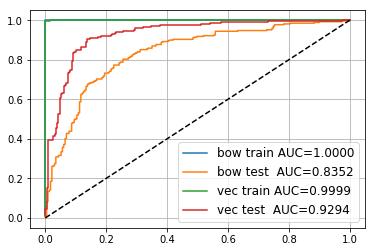

In [ ]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

If everything went right, you've just managed to reduce misclassification rate by a factor of two.
This trick is very useful when you're dealing with small datasets. However, if you have hundreds of thousands of samples, there's a whole different range of methods for that. We'll get there in the second part.